# PSRFITS: Tutorial 6

This notebook will build on the previous tutorials, showing more features of the `PsrSigSim`. Details will be given for new features, while other features have been discussed in the previous tutorial notebook. This notebook shows the details of saving simulated data to a `PSRFITS` file. In order to do this, you must have a currently existing `PSRFITS` file, taken in a fold-mode (as opposed to search mode) format. However, regardless of the initial information in the template `PSRFITS` file, the simulated data as well as corresponding properties of the simulated pulsar, should be saved in the new `PSRFITS` file that is saved.

We again simulate precision pulsar timing data with high signal-to-noise pulse profiles in order to clearly show the input pulse profile in the final simulated data product. We note that the use of different telescopes will result in different signal strengths, as would be expected. 

This example will follow previous notebook in defining all necessary classes except for `PSRFITS`.

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
import psrsigsim as pss

## The Folded Signal

Here we will use the same `Signal` definitions that have been used in the previous tutorials.  We will again simulate a 20 minute long observation total, with subintegrations of 1 minute. The other simulation parameters will be 64 frequency channels each 12.5 MHz wide (for 800 MHz bandwidth).

We will simulate a real pulsar, J1713+0747, as we have a premade profile for this pulsar. The period, dm, and other relavent pulsar parameters come from the NANOGrav 11-yr data release. 

In [2]:
# Define our signal variables.
f0 = 1500 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 64 # number of frequency channels
# We define the pulse period early here so we can similarly define the frequency
period = 0.00457 # pulsar period in seconds for J1713+0747
f_samp = (1.0/period)*2048*10**-6 # sample rate of data in MHz (here 2048 samples across the pulse period
sublen = 60.0 # subintegration length in seconds, or rate to dump data at
# Now we define our signal
signal_1713 = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                       sublen = sublen, fold = True) # fold is set to `True`

## The Pulsar and Profiles

Now we will load the pulse profile as in Tutorial 3 and intilialize a single `Pulsar` object. 

In [3]:
# First we load the data array
path = 'psrsigsim/data/J1713+0747_profile.npy'
J1713_dataprof = np.load(path)

# Now we define the data profile
J1713_prof = pss.pulsar.DataProfile(J1713_dataprof)

In [4]:
# Define the values needed for the puslar
Smean = 0.009 # The mean flux of the pulsar, J1713+0747 at 1400 MHz from the ATNF pulsar catatlog, here 0.009 Jy
psr_name = "J1713+0747" # The name of our simulated pulsar

# Now we define the pulsar with the scaled J1713+0747 profiles
pulsar_J1713 = pss.pulsar.Pulsar(period, Smean, profiles=J1713_prof, name = psr_name)

In [5]:
# define the observation length
obslen = 60.0*20 # seconds, 20 minutes in total

## The ISM

Here we define the `ISM` class used to disperse the simulated pulses.

In [6]:
# Define the dispersion measure
dm =  15.921200 # pc cm^-3
# And define the ISM object, note that this class takes no initial arguements
ism_sim = pss.ism.ISM()

## Defining Telescopes

Here we will will the predefined Green Bank Telescope with the predefined L-band system, as described in Tutorial 5.

In [7]:
# Define the Green Bank Telescope
tscope_GBT = pss.telescope.telescope.GBT()

## Observing the Pulsar

Now we will observe the pulsar using the simple parameters we have defined above.

In [8]:
# Make the pulses
pulsar_J1713.make_pulses(signal_1713, tobs = obslen)
# Disperse the pulses
ism_sim.disperse(signal_1713, dm)
# Observe with the GBT using the pre-defined GUPPI L-band system
tscope_GBT.observe(signal_1713, pulsar_J1713, system="Lband_GUPPI", noise=True)

98% dispersed in 0.113 seconds.

Now we can check to make sure that the simulated data arrays look like we want them to, looking at both the pulse profiles as well as the 2-D simulated data array.

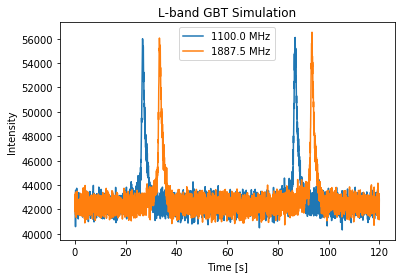

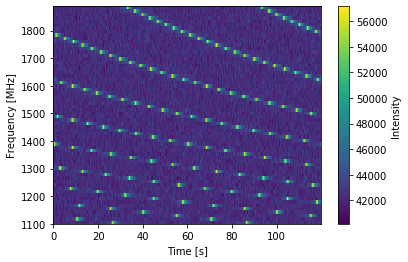

In [9]:
# We first plot the first two pulses in frequency-time space to show the undispersed pulses
time = np.linspace(0, obslen, len(signal_1713.data[0,:]))

# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713.data[0,:4096], label = signal_1713.dat_freq[0])
plt.plot(time[:4096], signal_1713.data[-1,:4096], label = signal_1713.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.title("L-band GBT Simulation")
plt.show()
plt.close()

# And the 2-D plot
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, \
                     signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

Since everything looks like we expect it to, we want to save the data in a `PSRFITS` style format so that it can be processed and manipulated further with your favorite pulsar analysis software, such as `PSRCHIVE` for example.

## Saving the Simulated Data as `PSRFITS`

Here we will go through the steps of saving the data in a `PSRFITS` format. Currently we do not build a new `PSRFITS` file from scratch but instead use a template `PSRFITS` file. All of this is done using the `PSRFITS` class that is part of the `io` class in the `PsrSigSim`. Currently only fold-mode data can be saved as `PSRFITS` format (though search mode saving will be available in the future). There are a number of inputs that can be defined for saving the data in a `PSRFITS` style format as well that will be discussed in depth below.

First we start by loading in our template `PSRFITS` file. Here we will need to include the name of the output `PSRFITS` file. We will call this `test_psrfits.fits`.

In [12]:
# Define the path to the template PSRFITS file
tempfits = "data/B1855+09.L-wide.PUPPI.11y.x.sum.sm"
# Now define the name of the output file
outfits = "test_psrfits.fits"
# Now load the template fits file. This also create draft output fits file at the same time.
pfit = pss.io.PSRFITS(path=outfits, template=tempfits, obs_mode='PSR')

Here the `path` value is the path and output name of the output `PSRFITS` file which will contain the simulated data. The `template` variable is the path to the template `PSRFITS` file. The `obs_mode` variable tells the simulator that the template file is a fold-mode style `PSRFITS` file as opposed to a Search mode format. This is currently the only supported input for `obs_mode`. If this value is not defined, it will default to the format of the input file.

Next we need to pass the input simulated values to the `PSRFITS` object (`pfit`). This way when we save the simulated data it will know what all of the input parameters are and will save the simulated pulsar and signal metadata correctly. This is done with a simple function call.

In [13]:
# Pass the user-input simulated values to the PSRFITS object, the only input is the Signal object
pfit.get_signal_params(signal = signal_1713)

Now we have passed everything we need to to the `PSRFITS` object and we can call the `save` function. There are a number of optional inputs that can go into this `save` function. In the simplest possible case, the only inputs necessary are the `Signal` and `Pulsar` objects. If only these two options are provided, the `PsrSigSim` will create a very basic pulsar parameter file (or par file) called `"pulsarname"_sim.par`. This is done in order to recalculate and replace the POLYCOs within the simulated `PSRFITS` file so that subsequent folding of the simulated data is possible. This create par file can subsequently be used to time any TOAs generated with the simulated data using standard pulsar software such as TEMPO of PINT.

In [14]:
# Now save the simplest possible case
pfit.save(signal_1713, pulsar_J1713)

(20, 1, 64, 2048)
No parfile provided, creating par file J1713+0747_sim.par
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]
INFO: Set solar system ephemeris to link:
	https://data.nanograv.org/static/data/ephem/de421.bsp [pint.solar_system_ephemerides]


INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]



Finished writing and saving the file


/Users/bshapiroalbert/opt/anaconda3/lib/python3.7/site-packages/fitsio/fitslib.py:1393: FITSRuntimeWarning: warning, keyword 'TFORM5' has non-standard value type <class 'complex'>, Converting to string: '1j'
  warnings.warn(mess % (name,type(value),sval), FITSRuntimeWarning)
/Users/bshapiroalbert/opt/anaconda3/lib/python3.7/site-packages/fitsio/fitslib.py:1393: FITSRuntimeWarning: warning, keyword 'TFORM11' has non-standard value type <class 'complex'>, Converting to string: '1j'
  warnings.warn(mess % (name,type(value),sval), FITSRuntimeWarning)


The user can also provide a par file to the `save` function that will then be used to calculate the POLYCOs for the simulated data. Here we will use the par file that was created above. However, one must reload the template fits file in order to save a new version of the simulated data as a `PSRFITS` file.

In [16]:
# Reinstantiate the template and draft PSRFITS file
pfit = pss.io.PSRFITS(path=outfits, template=tempfits, obs_mode='PSR')
pfit.get_signal_params(signal = signal_1713)
# Define the user input path/to/parfile
parfile = "J1713+0747_sim.par"
# Now save using a user created par file
pfit.save(signal_1713, pulsar_J1713, parfile = parfile)

(20, 1, 64, 2048)
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]


INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]

Finished writing and saving the file


It is possible that one would want to use the `PsrSigSim` in order to simulate a data set of phase connected observations. As the `PsrSigSim` can only simulate a single observation at a time it is necessary to keep track of various reference times and values in order to make sure that all simulated epochs retain their phase connection. As such there a number of additional input values that may be used for simulating larger phase connected data sets.

First is the `MJD_start` value. This tells the `PsrSigSim` what the start MJD of the simulated observation should be recorded as. This allows the user to steadily increment the start MJD of the observations they are simulating if desired. 

The `segLength` variable tell the simulator how long the POLYCOs that are generated are valid for (in minutes). The default is 60 minutes, so if longer observations are simulated, segLength should be increased appropriately, and should always be longer than the lenght of the simulated observation.

The `ref_MJD` is the MJD that all subsequent simulated epochs, and thus the POLYCOs, are referenced to. This can be any value in MJD but must be the same for all simulated epochs within a phase connected data set. For example, if three separate observations are simulated as part of a data set, they must all have the samve `ref_MJD` or they will lose phase connection.

In [17]:
# Reinstantiate the template and draft PSRFITS file
pfit = pss.io.PSRFITS(path=outfits, template=tempfits, obs_mode='PSR')
pfit.get_signal_params(signal = signal_1713)
# Define the user input path/to/parfile
parfile = "J1713+0747_sim.par"
# Now save the data
pfit.save(signal_1713, pulsar_J1713, parfile = parfile, MJD_start = 57000.0, segLength = 60.0, ref_MJD = 56000.0)

(20, 1, 64, 2048)
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]


INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True) [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]



Finished writing and saving the file
